In [1]:
from __future__ import division

import os, sys, time

import numpy as np
import scipy.linalg as sl, scipy.stats, scipy.special
import matplotlib.pyplot as plt
import libstempo as t2

from enterprise.pulsar import Pulsar
import enterprise.constants as const
from enterprise.signals import parameter
from enterprise.signals import utils
from enterprise.signals import prior
from enterprise.signals import selections
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import signal_base

from gibbs import Gibbs

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
from corner import corner

% matplotlib inline
%config InlineBackend.figure_format = 'retina'

Do not have mpi4py package.


In [2]:
datadir = '/Users/jaellis/Work/pulsar_data/nanograv/nanograv_5yr/'
parfile = datadir + 'par/J1643-1224_NANOGrav_dfg+12.par'
timfile = datadir + 'tim/J1643-1224_NANOGrav_dfg+12.tim'

#datadir = '/Users/jaellis/Work/pulsar_data/nanograv/nanograv_timing_2017/working/J1713+0747/'
#parfile = datadir + 'J1713+0747.dmx.t2.par'
#timfile = datadir + 'J1713+0747.dmx.tim'

#datadir = '/Users/jaellis/Work/pulsar_data/nanograv/nanograv_timing_2017/working/J0030+0451//'
#parfile = datadir + 'J0030+0451.initial.dmx6.par'
#timfile = datadir + 'J0030+0451.initial.dmx6.tim'

#parfile = '/Users/jaellis/Work/pulsar_data/nanograv/nanograv_timing_2013/release/par/B1937+21_NANOGrav_9yv1.gls.par'
#timfile = '/Users/jaellis/Work/pulsar_data/nanograv/nanograv_timing_2013/release/tim/B1937+21_NANOGrav_9yv1.tim'

#parfile = 'simulated_data/outliers/J1713+0747.par'
#timfile = 'simulated_data/outliers/J1713+0747.tim'

#parfile = 'simulated_data/gaussian/J1713+0747.par'
#timfile = 'simulated_data/gaussian/J1713+0747.tim'

#parfile = 'simulated_data/studentt/J1713+0747.par'
#timfile = 'simulated_data/studentt/J1713+0747.tim'

psr = Pulsar(parfile, timfile)

In [3]:
# white noise
efac = parameter.Uniform(0.2, 10)
#efac = parameter.Constant(1.0)
equad = parameter.Uniform(-10, -5)
ecorr = parameter.Uniform(-8, -5)

# backend selection
#selection = selections.Selection(selections.by_backend)
selection = selections.Selection(selections.no_selection)

ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.EquadNoise(log10_equad=equad, selection=selection)
ec = gp_signals.EcorrBasisModel(log10_ecorr=ecorr, selection=selection)

# red noise
pl = utils.powerlaw(log10_A=parameter.Uniform(-18,-12), gamma=parameter.Uniform(0,7))
rn = gp_signals.FourierBasisGP(spectrum=pl, components=20)

# timing model
tm = gp_signals.TimingModel()

# combined signal
s = ef + eq  + rn + tm + ec
              
# PTA
pta = signal_base.PTA([s(psr)])

In [4]:
pta.params

["1643-1224_efac":Uniform(0.2,10),
 "1643-1224_gamma":Uniform(0,7),
 "1643-1224_log10_A":Uniform(-18,-12),
 "1643-1224_log10_ecorr":Uniform(-8,-5),
 "1643-1224_log10_equad":Uniform(-10,-5)]

In [5]:
mdls = []
labels = ['vvh17', 'individual', 'uniform', 'beta', 'gaussian', 't']
# emulate Vallisneri and van Haasteren mixture model
# what should alpha be?
gibbs = Gibbs(pta, model='vvh17', vary_df=False, theta_prior='uniform', 
               vary_alpha=False, alpha=1e10, pspin=0.00457)
mdls.append(gibbs)

#gibbs = Gibbs(pta, model='mixture')
#mdls.append(gibbs)

# uniform theta distribution
#gibbs = Gibbs2(pta, model='mixture', vary_df=True, theta_prior='uniform')
#mdls.append(gibbs)

# beta theta distribution
#gibbs = Gibbs2(pta, model='mixture', vary_df=True, theta_prior='beta')
#mdls.append(gibbs)

# Gaussian
#gibbs = Gibbs2(pta, model='gaussian', vary_df=True, theta_prior='beta')
#mdls.append(gibbs)

# t-distribution
#gibbs = Gibbs2(pta, model='t', vary_df=True, theta_prior='beta')
#mdls.append(gibbs)


In [6]:
for md in mdls:
    print md
    params = np.array([p.sample() for p in md.params]).flatten()
    niter = 10000
    md.sample(params, niter=niter)
    

Finished 99 percent in 522.89 seconds..

In [25]:
md = mdls[0]
key = 'vvh17'
idx = 'J1713+0747'
np.save('output/{}/{}/chain.npy'.format(key, idx), md.chain[100:,:])
np.save('output/{}/{}/bchain.npy'.format(key, idx), md.bchain[100:,:])
np.save('output/{}/{}/zchain.npy'.format(key, idx), md.zchain[100:,:])
np.save('output/{}/{}/poutchain.npy'.format(key, idx), md.poutchain[100:,:])
np.save('output/{}/{}/thetachain.npy'.format(key, idx), md.thetachain[100:])
np.save('output/{}/{}/alphachain.npy'.format(key, idx), md.alphachain[100:,:])
np.save('output/{}/{}/dfchain.npy'.format(key, idx), md.dfchain[100:])

In [10]:
len(params)

17

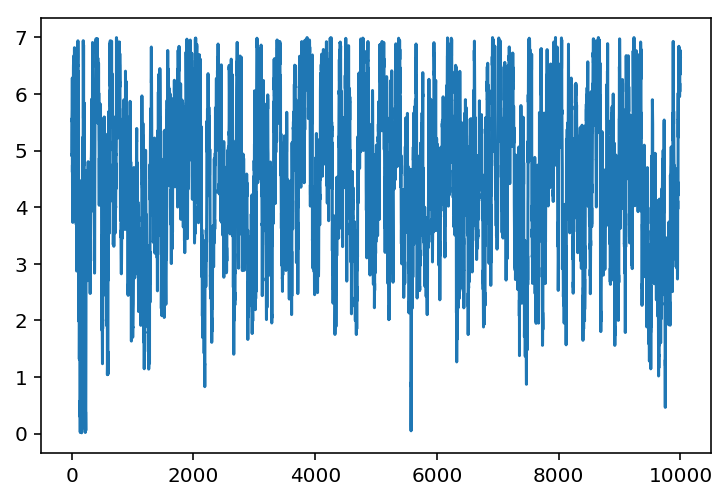

In [7]:
plt.plot(mdls[0].chain[:, -4])

In [36]:
psr.flags['snr']

array(['86.432', '24.207', '66.608', ..., '18.56', '12.058', '13.038'],
      dtype='|S32')

vvh17 90


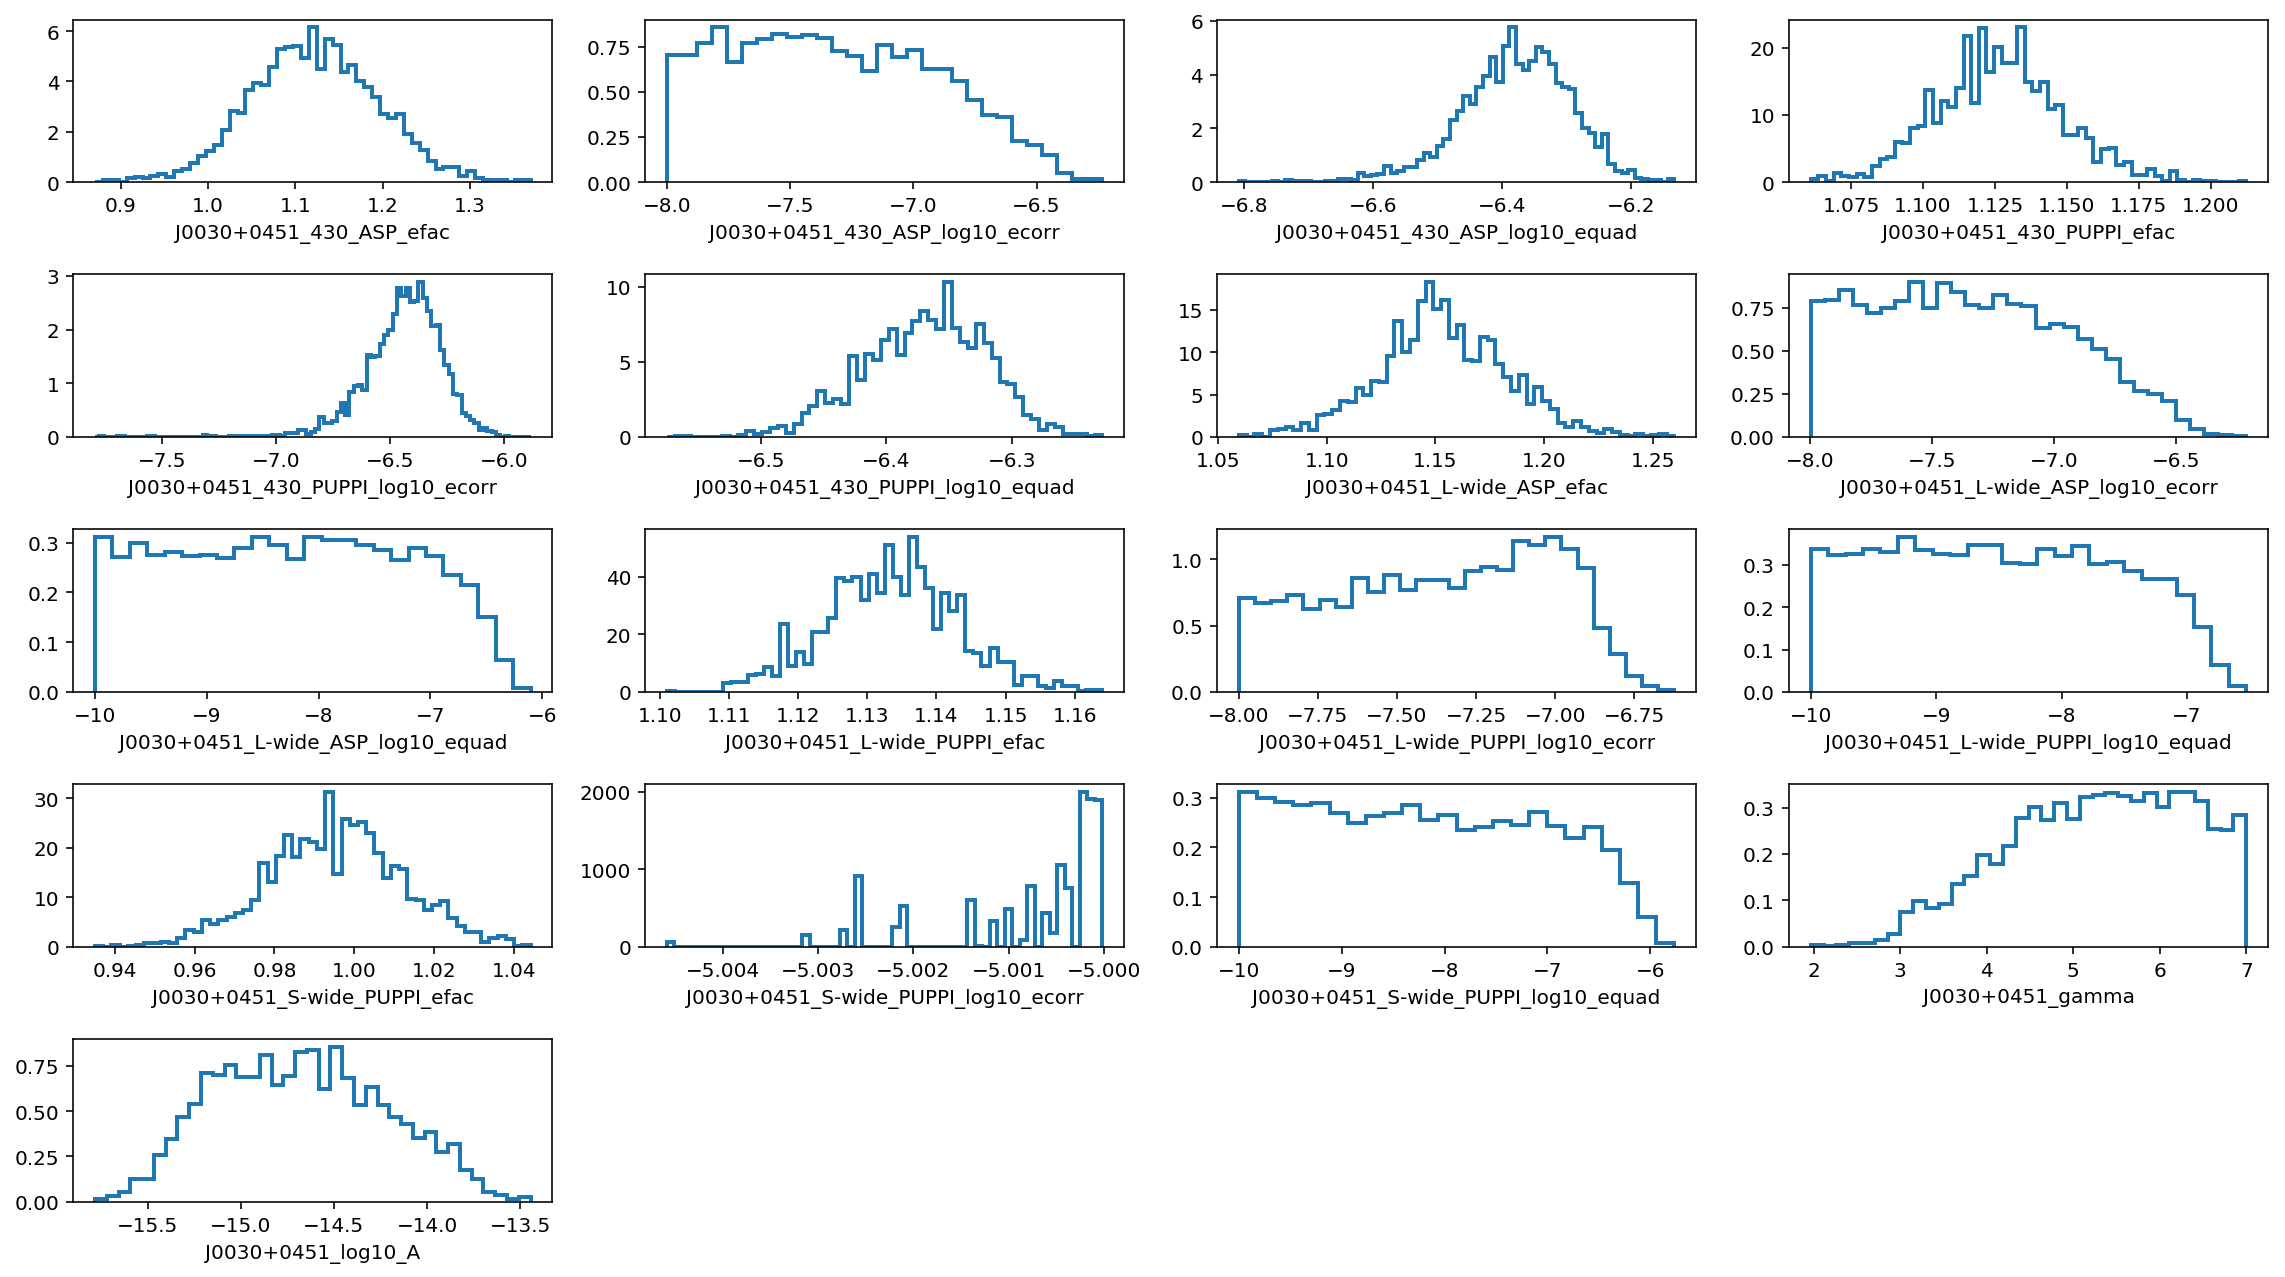

In [43]:
plt.figure(figsize=(16,9))
for md, label in zip(mdls, labels):
    pars = sorted([par.name for par in md.params])
    out = np.flatnonzero(md.zchain.mean(axis=0)>0.90)
    print label, len(out)
    for ii in range(17):
        plt.subplot(5,4,ii+1)
        plt.hist(md.chain[300:,ii], bins='auto', normed=True, histtype='step', lw=2, label=label)
        plt.xlabel(pars[ii])
plt.tight_layout()

In [26]:
params

array([  6.3760851 ,  -9.11477941,  -9.30457669,   7.55391994,
        -5.99934331,  -7.96620773,   8.2007496 ,  -5.0018007 ,
        -9.91756468,   4.64375381,  -9.67134501,  -6.498775  ,
         6.44974724,  -6.53287322,  -7.34569988,   1.15833843, -14.91503293])

In [8]:
mpars = np.load('/Users/jaellis/Downloads/J1643-1224-pars.npy')

In [9]:
pmap = {'1643-1224_efac': 0, '1643-1224_gamma': 4, 
        '1643-1224_log10_A': 3, '1643-1224_log10_ecorr': 2, 
        '1643-1224_log10_equad': 1}

vvh17 2


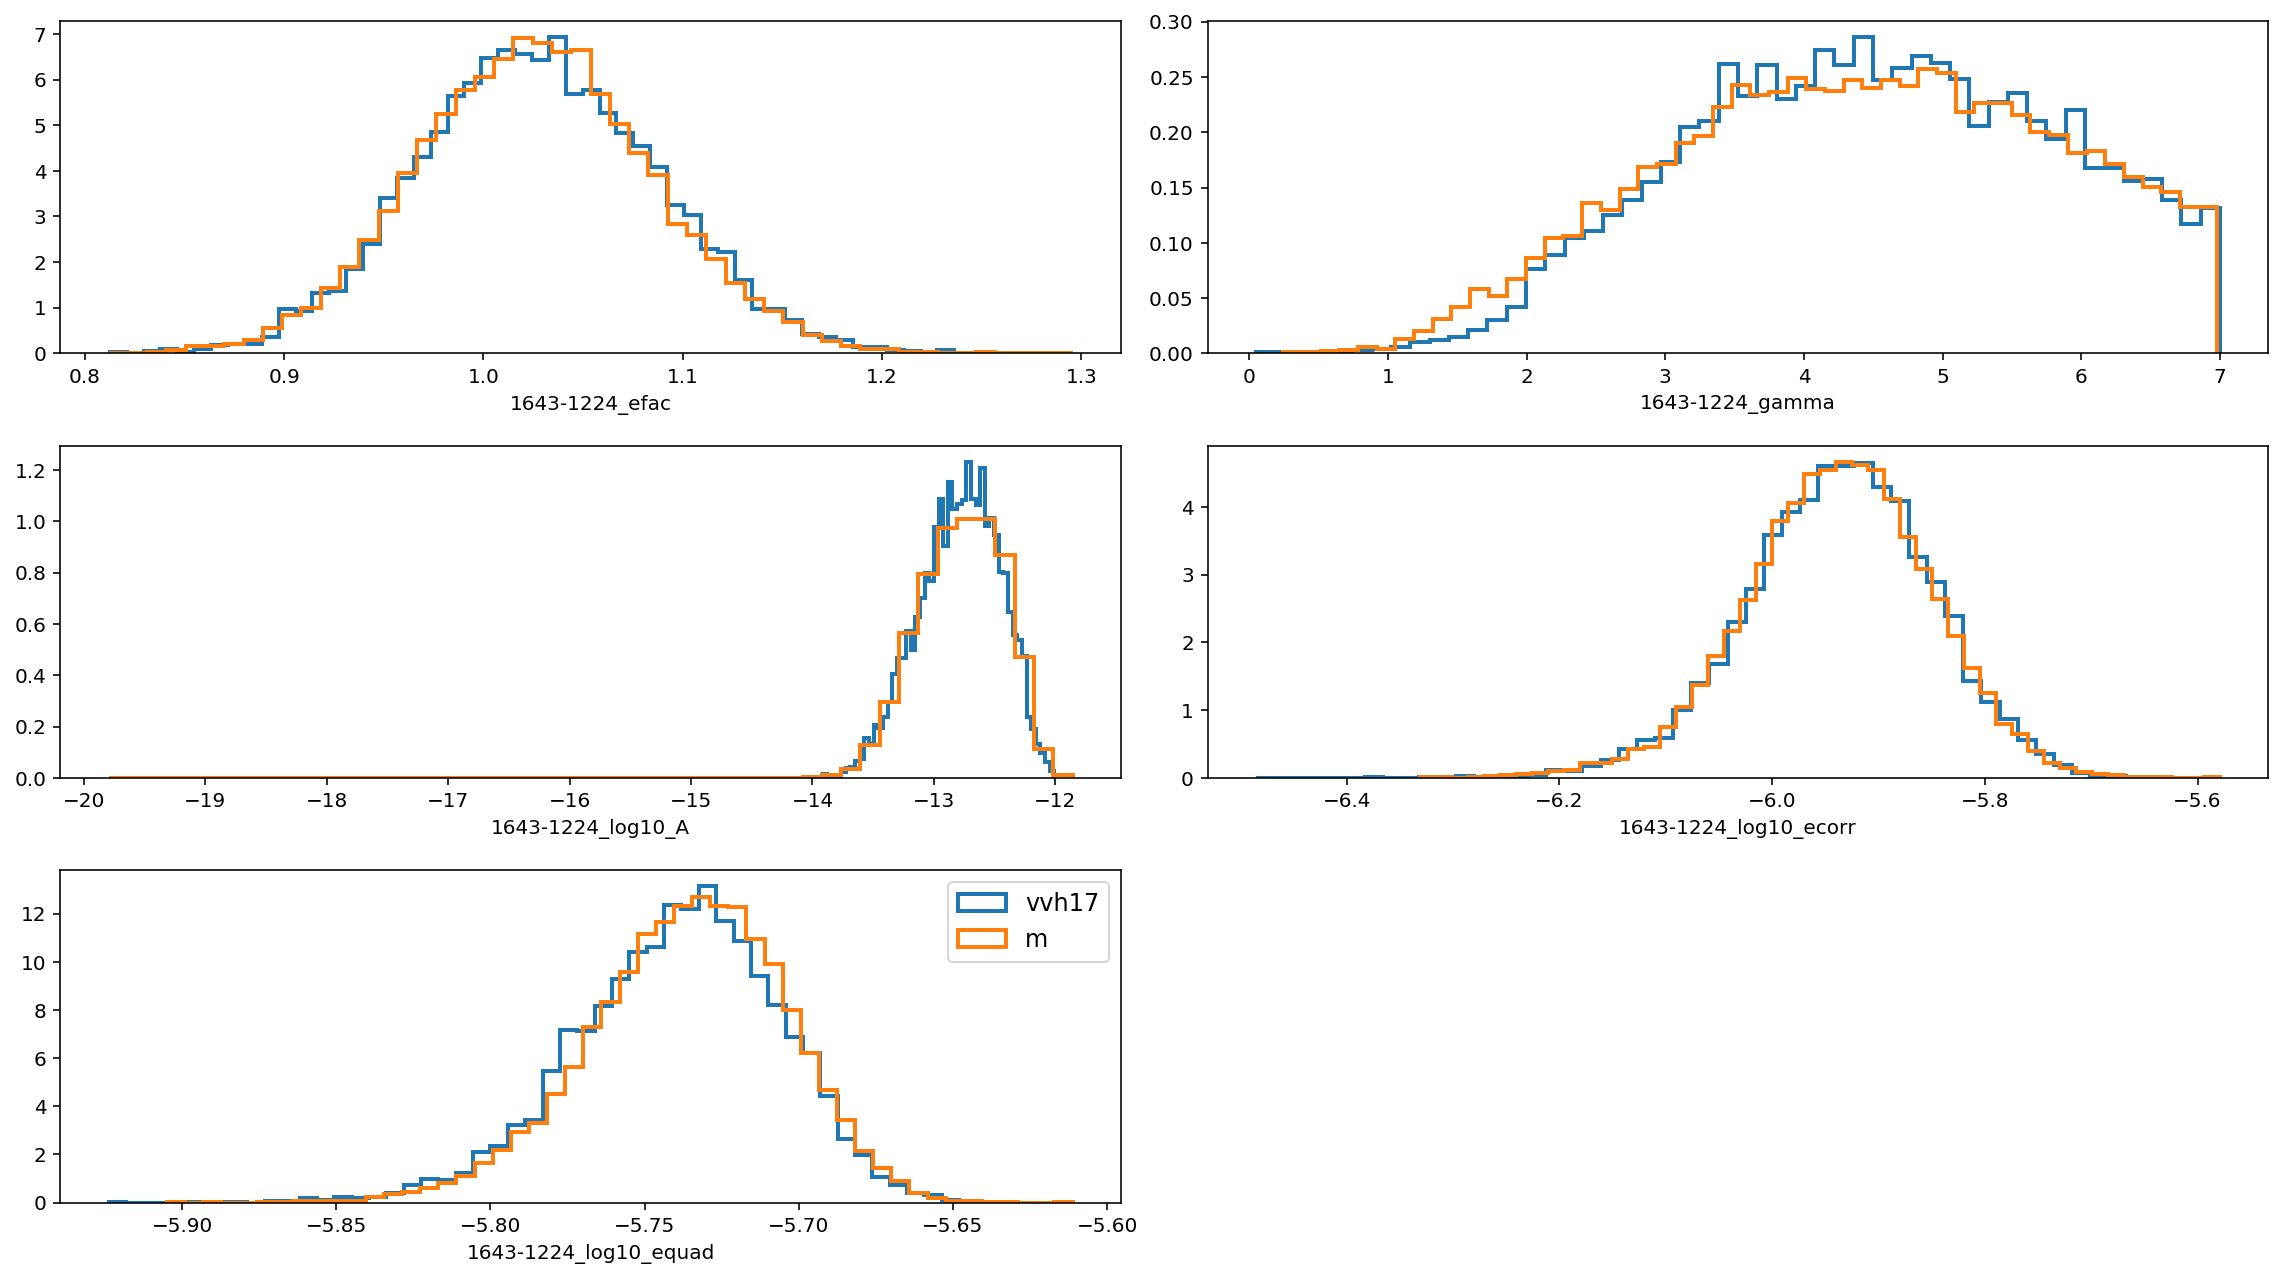

In [16]:
labels = ['vvh17', 'uniform', 'beta', 'gaussian', 't']
labels = ['vvh17', 'vvh172']
plt.figure(figsize=(16,9))
mdls2 = [mdls[0]]
for md, label in zip(mdls2, labels):
    pars = sorted([par.name for par in md.params])
    out = np.flatnonzero(md.zchain.mean(axis=0)>0.90)
    print label, len(out)
    for ii in range(5):
        plt.subplot(3,2,ii+1)
        plt.hist(md.chain[1000:,ii], bins=50, normed=True, histtype='step', lw=2, label=label)
        plt.xlabel(pars[ii])
for ii in range(5):
    plt.subplot(3,2,ii+1)
    plt.hist(mpars[1000:,pmap[pars[ii]]], bins=50, normed=True, histtype='step', lw=2, label='m')
plt.tight_layout()
plt.legend(loc='best', fontsize=12)

#plt.savefig('hyper_pars_t.pdf', bbox_inches='tight')

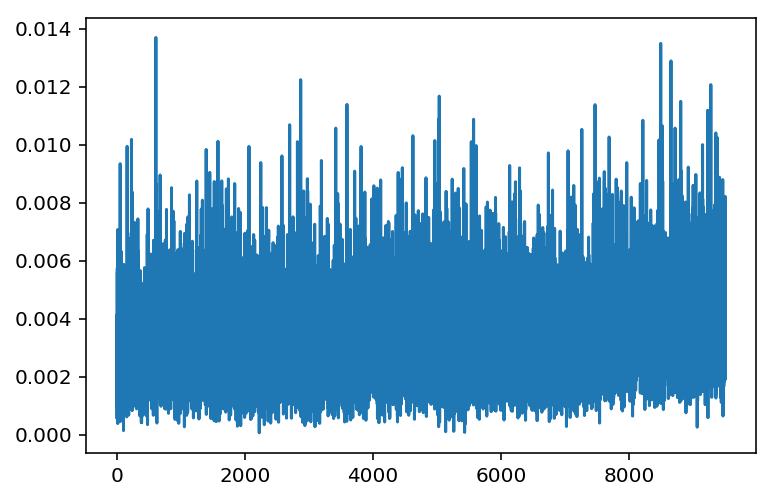

In [11]:
plt.plot(md.thetachain[500:])

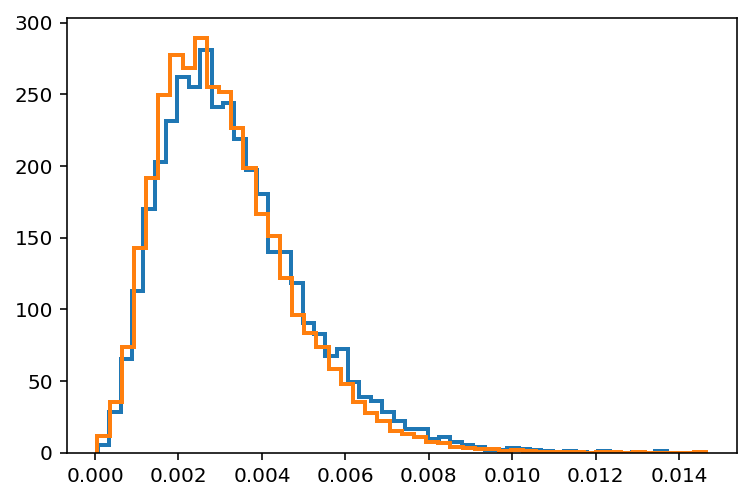

In [13]:
plt.hist(md.thetachain[500:], 50, normed=True, histtype='step', lw=2);
plt.hist(mpars[:, 5], 50, normed=True, histtype='step', lw=2);

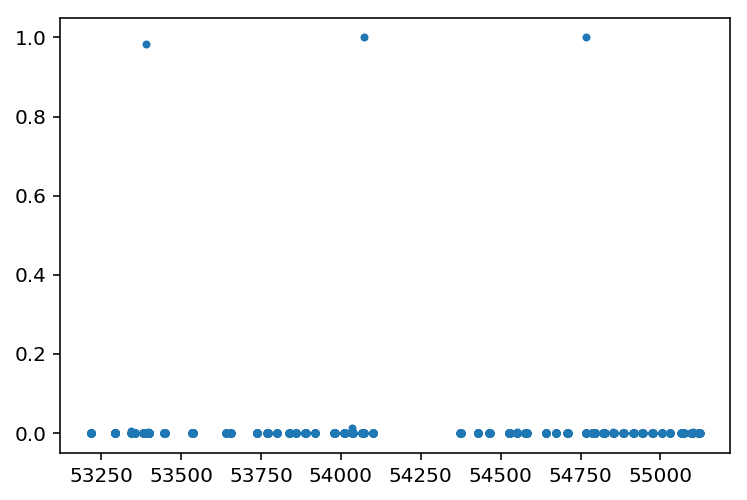

In [14]:
pout = md.poutchain
plt.plot(psr.toas/86400, np.median(pout, axis=0), '.')

<Container object of 3 artists>

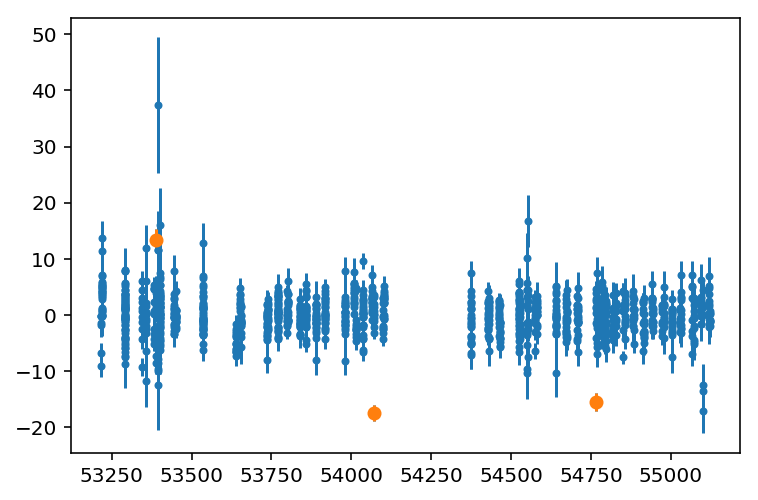

In [18]:
out = np.median(pout, axis=0) > 0.9
plt.errorbar(psr.toas/86400, psr.residuals*1e6, psr.toaerrs*1e6, fmt='.')
plt.errorbar(psr.toas[out]/86400, psr.residuals[out]*1e6, psr.toaerrs[out]*1e6, fmt='o')

vvh17 15


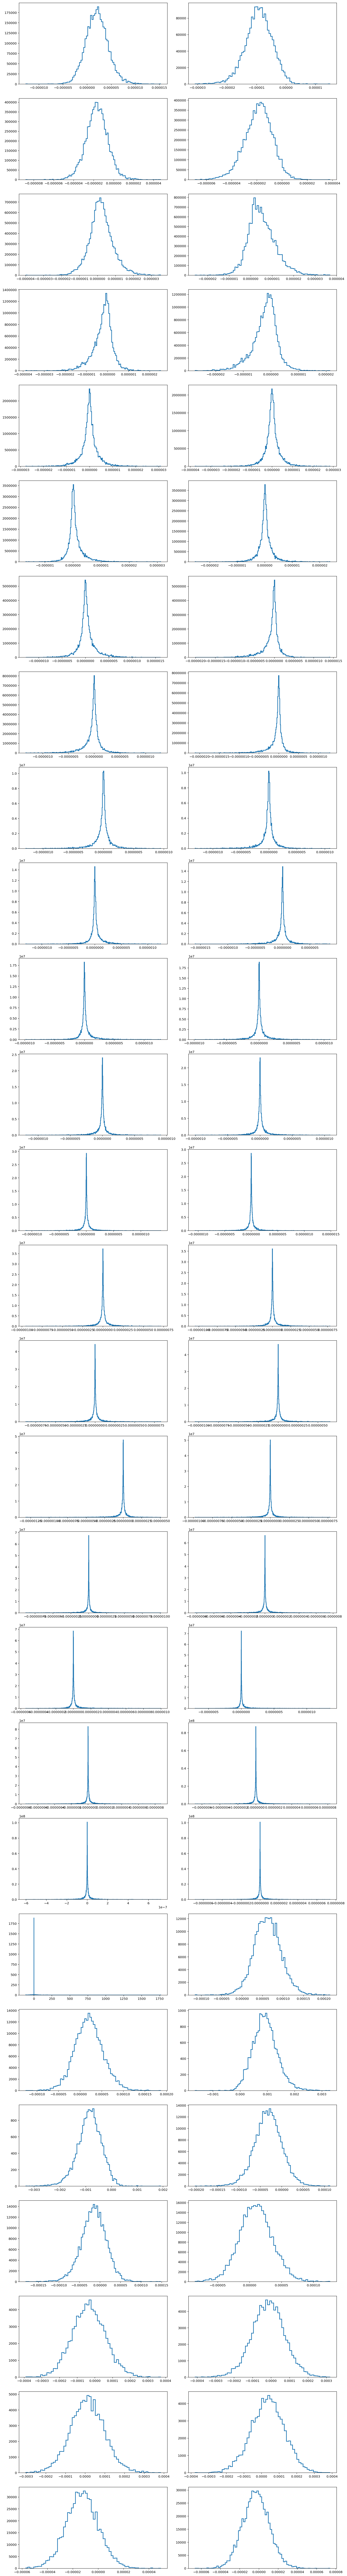

In [14]:
labels = ['vvh17', 'uniform', 'beta', 'gaussian', 't']
plt.figure(figsize=(15,3*37))
for md, label in zip(mdls, labels):
    pars = sorted([par.name for par in md.params])
    out = np.flatnonzero(md.zchain.mean(axis=0)>0.90)
    print label, len(out)
    for ii in range(54):
        plt.subplot(27,2,ii+1)
        plt.hist(md.bchain[300:,ii], bins='auto', normed=True, histtype='step', lw=2, label=label)
        #plt.title(pars[ii])
plt.tight_layout()
#plt.savefig('b_pars_t.pdf', bbox_inches='tight')

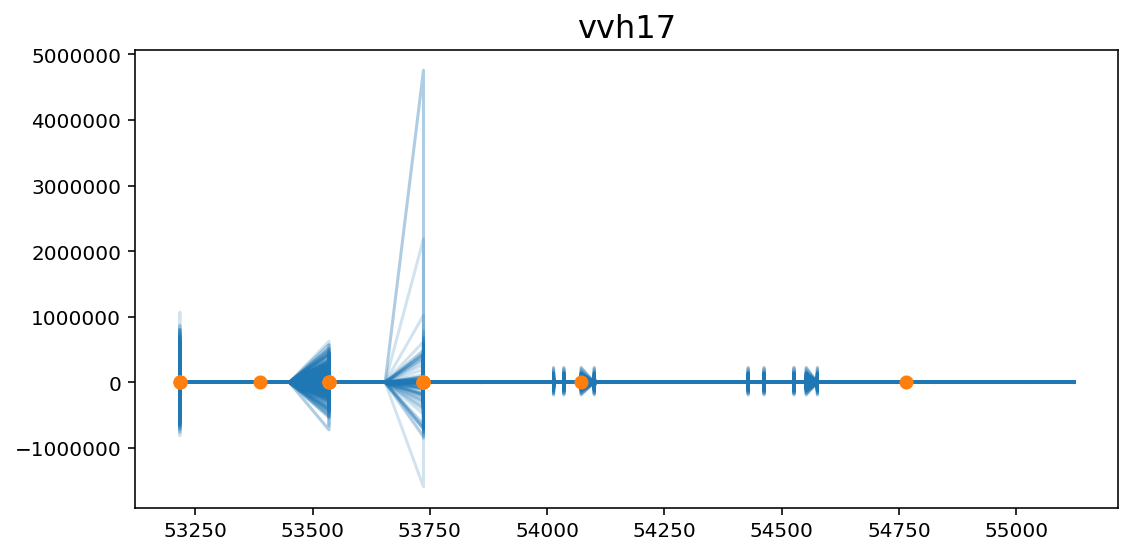

In [15]:
plt.figure(figsize=(8,3*6))
ct = 0
for md, label in zip(mdls, labels):
    plt.subplot(5,1,ct+1)
    Tmat = pta.get_basis()[0]
    out = np.flatnonzero(md.zchain.mean(axis=0)>0.90)
    for ii in range(500):
        ind = np.random.randint(100, 10000)
        plt.plot(psr.toas/86400, np.dot(Tmat, md.bchain[ind, :])*1e6, color='C0', alpha=0.2)
    #plt.errorbar(psr.toas/86400, psr.residuals*1e6, psr.toaerrs*1e6, fmt='.', color='k')
    if len(out) < len(psr.toas):
        plt.errorbar(psr.toas[out]/86400, psr.residuals[out]*1e6, psr.toaerrs[out]*1e6, fmt='o', color='C1')
    plt.title(label, fontsize=16)
    ct += 1
plt.tight_layout()
#plt.savefig('waveform_t.pdf', bbox_inches='tight')

<Container object of 3 artists>

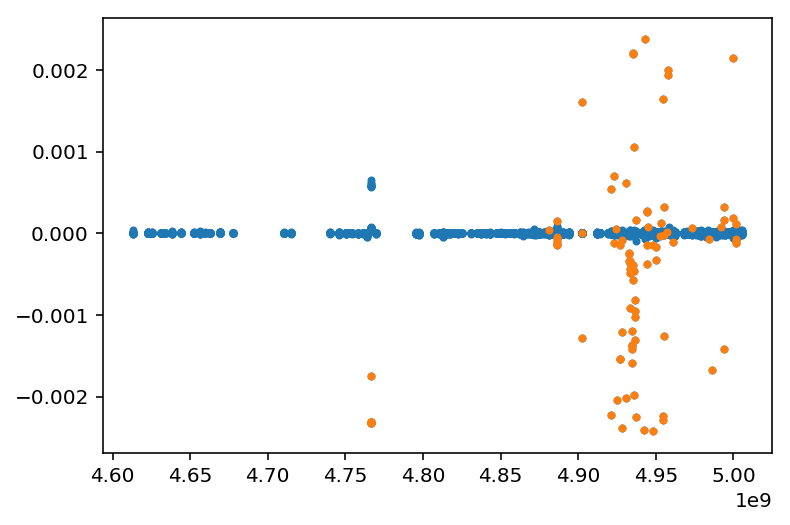

In [24]:
out = np.flatnonzero(np.median(mdls[0].poutchain[300:,:], axis=0)>0.2)
plt.errorbar(psr.toas, psr.residuals, psr.toaerrs, fmt='.')
plt.errorbar(psr.toas[out], psr.residuals[out], psr.toaerrs[out], fmt='.')

In [23]:
np.median(mdls[0].poutchain[300:,:], axis=0).shape

(12863,)

In [25]:
for o in out:
    print np.median(mdls[0].poutchain[500:,o])


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.999957937523
1.0
0.999999995422
1.0
0.99999999798
1.0
0.999947871079
0.335163085299
1.0
1.0
1.0
1.0
0.999547483989
1.0
0.971085396402
1.0
1.0
1.0
1.0
1.0
0.999995054878
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.438106367535
0.999999984915
1.0
1.0
1.0
0.493123593023
1.0
1.0
0.32413559306
1.0
1.0
0.999999999992
0.999999999792
0.610448633871
1.0
0.920400157418
1.0
0.999999999986
1.0
1.0
1.0
0.999999999242
0.998698626564
0.998982058073
0.98338484965


RuntimeError: 

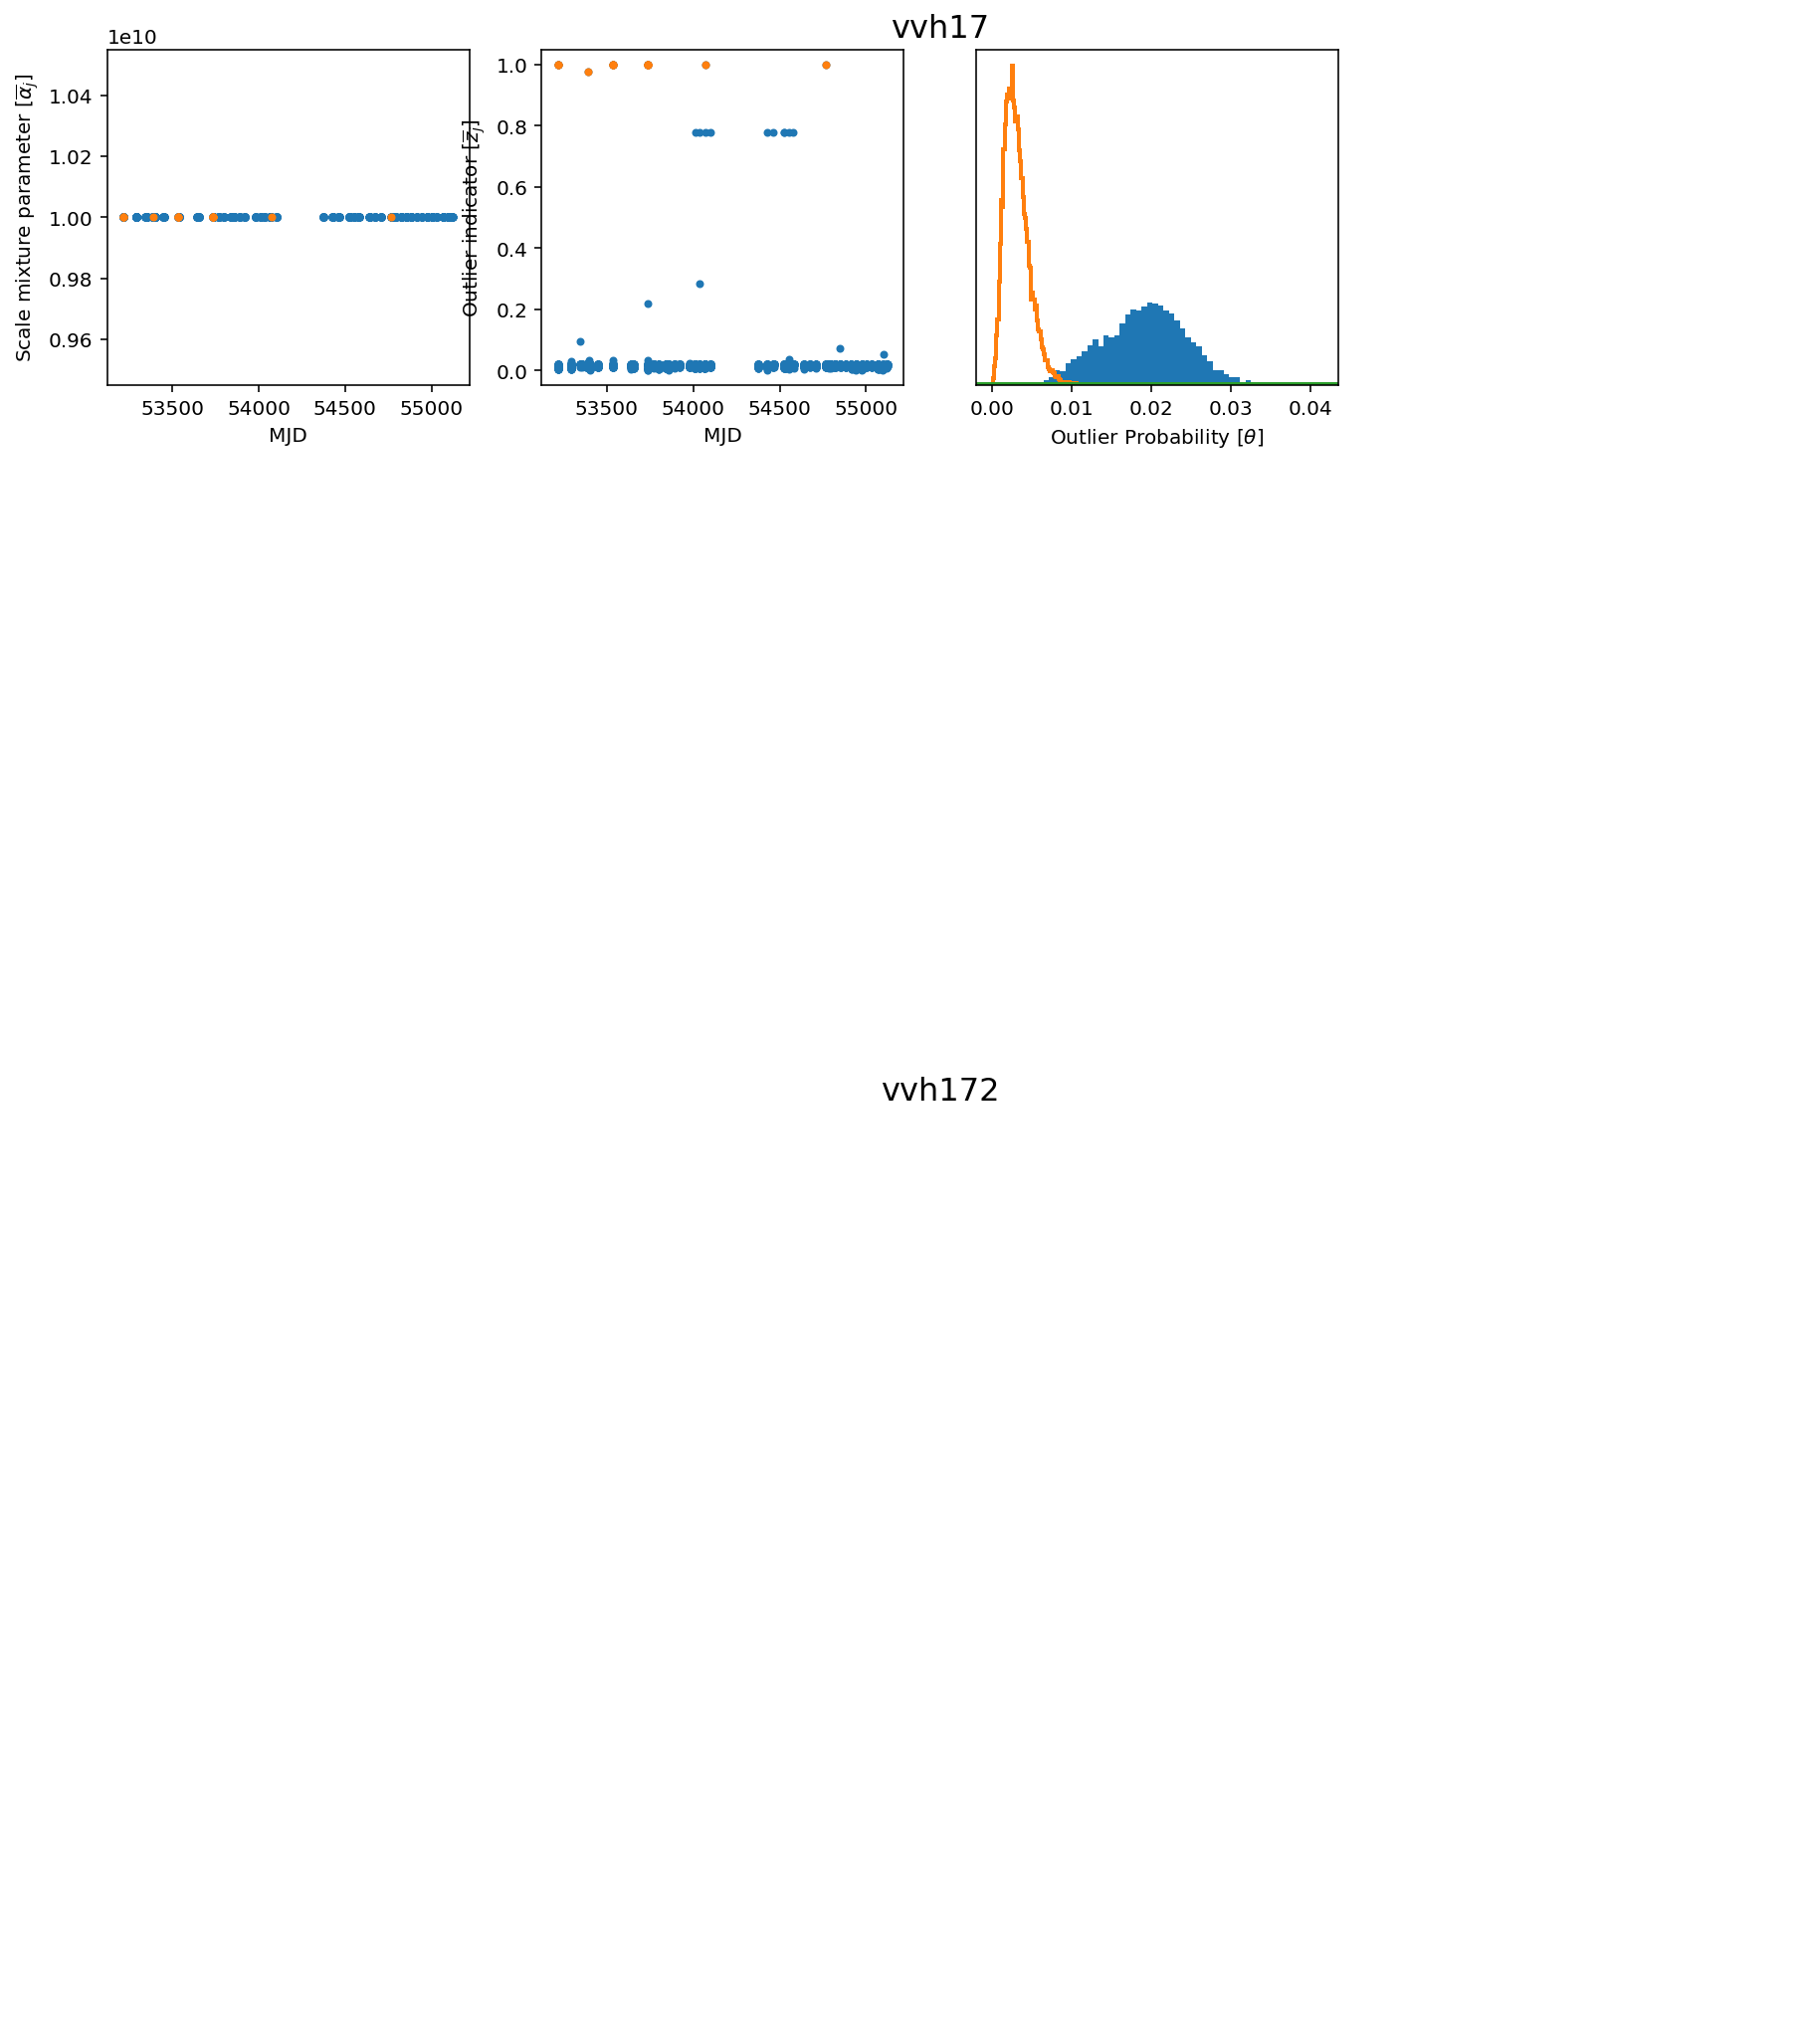

In [16]:
fig, big_axes = plt.subplots( figsize=(15.0, 3*6) , nrows=2, ncols=1, sharey=False) 
labels = ['vvh17', 'vvh172']
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(labels[row-1], fontsize=16)

    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False
    
ct = 0
for md, label in zip(mdls, labels):
    ax = fig.add_subplot(5,4,4*ct+1)
    out = np.flatnonzero(md.zchain.mean(axis=0)>0.90)
    plt.plot(psr.toas/86400, md.alphachain[1000:,:].mean(axis=0), '.')
    plt.plot(psr.toas[out]/86400, md.alphachain[1000:,out].mean(axis=0), '.')
    plt.ylabel(r'Scale mixture parameter [$\overline{\alpha}_j$]')
    plt.xlabel(r'MJD')
    
    ax = fig.add_subplot(5,4,4*ct+2)
    plt.plot(psr.toas/86400, md.zchain.mean(axis=0), '.')
    #plt.plot(psr.toas/86400, np.median(md.poutchain, axis=0), '.')
    plt.plot(psr.toas[out]/86400, md.zchain.mean(axis=0)[out], '.')
    plt.ylabel(r'Outlier indicator [$\overline{z}_j$]')
    plt.xlabel(r'MJD')
    
    if label in ['vvh17', 'uniform', 'beta']:
        ax = fig.add_subplot(5,4,4*ct+3)
        plt.hist(md.thetachain[1000:], bins='auto', normed=True);
        if label == 'beta':
            k = len(psr.residuals)
            m = 0.01
            y = scipy.stats.beta(k*m, k*(1-m))
            x = np.linspace(0.0, md.thetachain[1000:].max(), 1000)
            plt.plot(x, y.pdf(x), lw=2, color='C2')
        else:
            plt.axhline(1, lw=2, color='C2')
        ax.get_yaxis().set_visible(False)
        plt.xlabel(r'Outlier Probability [$\theta$]')
        if label == 'vvh17':
            plt.hist(mpars[:,5], bins='auto', normed=True, histtype='step', lw=2, color='C1')
     
    if label in ['uniform', 'beta', 't']:
        ax = fig.add_subplot(5,4,4*ct+4)
        dfs = np.unique(md.dfchain[1000:])
        counts = np.array([sum(md.dfchain[1000:]==df) for df in dfs])
        plt.bar(dfs, counts, align='center')
        ax.get_yaxis().set_visible(False)
        plt.xlabel('t-disribution d.o.f')
    ct += 1
plt.tight_layout()
#plt.savefig('outlier_pars_t.pdf', bbox_inches='tight')

plt.plot(mdls[1].thetachain[100:])

In [ ]:
plt.hist(mdls[0].thetachain[100:], 50, normed=True);
plt.hist(mdls[5].thetachain[100:], 50, normed=True);

In [ ]:
mdls